# Titanic - Machine Learning from Disaster

<img src='files/titanic.jpg'>

   - image reference  : <a href="https://www.google.com/search?q=titanic+&tbm=isch&ved=2ahUKEwjJvPq3lb_xAhVdnksFHUXCBwUQ2-cCegQIABAA&oq=titanic+&gs_lcp=CgNpbWcQAzIECCMQJzIECCMQJzIHCAAQsQMQQzIFCAAQsQMyBAgAEEMyBAgAEEMyBwgAELEDEEMyBwgAELEDEEMyBAgAEEMyBQgAELEDUL7IA1i-yANg99MDaABwAHgAgAGaAogBmgKSAQMyLTGYAQCgAQGqAQtnd3Mtd2l6LWltZ8ABAQ&sclient=img&ei=7EncYMmWJd28rtoPxYSfKA&bih=625&biw=1349&rlz=1C1CHBF_enIN893IN893&hl=en#imgrc=o3A3LT1rCbmhjM">titanic image</a>

This notebook will use ensemble method to give the predictions. First, a model will be created using a decision tree without any hyperparameter tuning. Then a second model will be created using random forest classifier with some optimized parameters. Than the output of these 2 models will be ensembled with the gender_submission.csv file to give the final output.

## 1. Importing libraries

In [1]:
#to work with dataframes/tables
import pandas as pd

#to work with multidimensional numerical arrays with some maths functions
import numpy as np  

#for visualization purpose
import matplotlib.pyplot as plt    
import seaborn as sns

#regular expression to work with strings
import re

#to convert categorical features into numerical features
from sklearn.preprocessing import LabelEncoder

#to split our data set into training set and testing set
from sklearn.model_selection import cross_val_score,train_test_split

#training algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# metrics to evaluate our model
from sklearn.metrics import accuracy_score

#to avoid future warnings
import warnings
warnings.filterwarnings('ignore')

## 2. Importing datasets

In [2]:
train=pd.read_csv('train.csv') #dataset with labels(survived column)
test=pd.read_csv('test.csv')  #dataset without labels

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
#setting index column
train=train.set_index('PassengerId')
test=test.set_index('PassengerId')

###  Shape of the data

In [6]:
#checking shapes of training & testing set
print('Training set has {} rows/observations and {} features/columns'.format(train.shape[0],train.shape[1]))
print('Testing set has {} rows/observations and {} features/columns'.format(test.shape[0],test.shape[1]))

Training set has 891 rows/observations and 11 features/columns
Testing set has 418 rows/observations and 10 features/columns


###  Missing Values

In [7]:
#checking for null values
print('Nulls in training set\n\n',train.isna().sum())
print('********************************')
print('\nNulls in testing set\n\n',test.isna().sum())

Nulls in training set

 Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64
********************************

Nulls in testing set

 Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64


- Triaing set has missing values in **Age, Cabin** & **Embarked** columns
- Testing set has missing values in **Age, Fare** & **Cabin** columns

#### concatenating both the datasets
   - As train and test data are both could be from different samples, combining them can give the whole distribution
   - This will help us to deal with missing values in a better way

In [8]:
df=pd.concat([train,test],axis=0,sort=False)

In [9]:
print(df.shape)

(1309, 11)


In [10]:
print(df.isna().sum())

Survived     418
Pclass         0
Name           0
Sex            0
Age          263
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin       1014
Embarked       2
dtype: int64


- **Survived** column has null values because there is no survived column in testing set

## 3. Approach 1

In this approach, we will create some new features and develop our first model on the basis of those features.

Our first model will be DecisionTreeClassifier

### Exploratory Data Analysis

### 3.1 Creating pivot tables or cross tables

In [11]:
df1=df.copy()

In [12]:
df1_train=df1.loc[train.index]
df1_test=df1.loc[test.index]

In [13]:
#checking survival rate distribution group by Sex and Pclass
pd.pivot_table(df1_train,index=['Sex'],columns=['Pclass'],values=['Survived'],aggfunc='mean')

Survived                    
Pclass         1         2         3
Sex                                 
female  0.968085  0.921053  0.500000
male    0.368852  0.157407  0.135447

- **Females** have higher Survival rate in class 1 and 2
- Survival rate of **Males** is poor irrespective of their class

In [14]:
#extracting title from name
df1_train['title']=df1_train['Name'].apply(lambda x:re.split('[.,]',x)[1].strip())

df1_test['title']=df1_test['Name'].apply(lambda x:re.split('[.,]',x)[1].strip())

In [15]:
df1_train['title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Col               2
Major             2
Jonkheer          1
Don               1
Lady              1
Mme               1
Sir               1
Capt              1
the Countess      1
Ms                1
Name: title, dtype: int64

In [16]:
df1_test['title'].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Dr          1
Dona        1
Ms          1
Name: title, dtype: int64

In [17]:
#checking Survival rate group by title,Sex and Pclass
pd.pivot_table(df1_train,index=['Sex','title'],columns=['Pclass'],values=['Survived'])

Survived                    
Pclass                      1         2         3
Sex    title                                     
female Dr            1.000000       NaN       NaN
       Lady          1.000000       NaN       NaN
       Miss          0.956522  0.941176  0.500000
       Mlle          1.000000       NaN       NaN
       Mme           1.000000       NaN       NaN
       Mrs           0.976190  0.902439  0.500000
       Ms                 NaN  1.000000       NaN
       the Countess  1.000000       NaN       NaN
male   Capt          0.000000       NaN       NaN
       Col           0.500000       NaN       NaN
       Don           0.000000       NaN       NaN
       Dr            0.500000  0.000000       NaN
       Jonkheer      0.000000       NaN       NaN
       Major         0.500000       NaN       NaN
       Master        1.000000  1.000000  0.392857
       Mr            0.345794  0.087912  0.112853
       Rev                NaN  0.000000       NaN
       Sir           1.000000       NaN       NaN

- Survival rate of **Master** is 100% in class 1 and 2
- Either the survival rate is poor for other male titles or the count is very less
- Survival rate of **Miss and Mrs** is higher in class and 1 and 2
- Remaining other categories are very small in number.

In [18]:
#creating new feature for title==Master
df1_train['Master']=df1_train['title']=='Master'

df1_test['Master']=df1_test['title']=='Master'

In [19]:
# a female can be a single mom or a girl if she has no sibling/spouse and 1 parent/child
df1_train['girlOrSingleMum']=(df1_train['Sex']=='female')&(df1_train['SibSp']==0)&(df1_train['Parch']==1)

df1_test['girlOrSingleMum']=(df1_test['Sex']=='female')&(df1_test['SibSp']==0)&(df1_test['Parch']==1)

In [20]:
pd.pivot_table(df1_train,index=['girlOrSingleMum'],columns=['Sex','Pclass'],values=['Survived'])

Survived                                                  
Sex                female                          male                    
Pclass                  1         2         3         1         2         3
girlOrSingleMum                                                            
False            0.964286  0.913043  0.496350  0.368852  0.157407  0.135447
True             1.000000  1.000000  0.571429       NaN       NaN       NaN

- Survival rate of **girlsOrSingleMum** of class 3 is better than those who are not **girlOrSingleMums**

In [21]:
#checking Survival rate group by Embarked, Sex and Pclass
pd.pivot_table(df1_train,columns=['Embarked'],index=['Sex','Pclass'],values=['Survived'])

Survived                    
Embarked              C         Q         S
Sex    Pclass                              
female 1       0.976744  1.000000  0.958333
       2       1.000000  1.000000  0.910448
       3       0.652174  0.727273  0.375000
male   1       0.404762  0.000000  0.354430
       2       0.200000  0.000000  0.154639
       3       0.232558  0.076923  0.128302

- **Females** of **class 3** has higher survival rate who **embarked** from **Q**

In [22]:
#creating new feature on the basis of above info
df1_train['Fembarked_Q']=(df1_train['Sex']=='female')&(df1_train['Embarked']=='Q')&(df1_train['Pclass']==3)

df1_test['Fembarked_Q']=(df1_test['Sex']=='female')&(df1_test['Embarked']=='Q')&(df1_test['Pclass']==3)

In [23]:
df1_train.Ticket.nunique()

681

- Ticket column has too many unique values so we may need to drop this

In [24]:
df1_train.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'title', 'Master', 'girlOrSingleMum',
       'Fembarked_Q'],
      dtype='object')

### 3.2 Feature Selection

### Final Model:
- **Females** of **class 1 and 2** have higher survival rate
- **Females** of **class 3** have higher survival rate who **Embarked** from **Q**
- Girls or Single mothers have higher survival rate
- Those with the title **Master** have higher survival rate

Based on the above model following features will be selected :
   - **Pclass, Sex & Embarked**
   
New features created :
   - **Master, girlOrSingleMum, Fembarked_Q**

In [25]:
x=df1_train.drop(['Survived','Name','SibSp','Parch','Ticket','Fare','Age','Cabin','title'],axis=1)
df1_test=df1_test.drop(['Survived','Name','SibSp','Parch','Ticket','Age','Fare','Cabin','title'],axis=1)

In [26]:
x.head()

,Pclass,Sex,Embarked,Master,girlOrSingleMum,Fembarked_Q
PassengerId,,,,,,
1,3,male,S,False,False,False
2,1,female,C,False,False,False
3,3,female,S,False,False,False
4,1,female,S,False,False,False
5,3,male,S,False,False,False


In [27]:
y=df1_train['Survived']

### 3.3 Label Encoding

In [28]:
le=LabelEncoder()
x['Master']=le.fit_transform(x['Master'])
x['girlOrSingleMum']=le.fit_transform(x['girlOrSingleMum'])
x['Fembarked_Q']=le.fit_transform(x['Fembarked_Q'])

df1_test['Master']=le.fit_transform(df1_test['Master'])
df1_test['girlOrSingleMum']=le.fit_transform(df1_test['girlOrSingleMum'])
df1_test['Fembarked_Q']=le.fit_transform(df1_test['Fembarked_Q'])

In [29]:
#Creating dummy columns
x=pd.get_dummies(x,drop_first=True)
df1_test=pd.get_dummies(df1_test,drop_first=True)

In [30]:
x.head()

,Pclass,Master,girlOrSingleMum,Fembarked_Q,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,
1,3,0,0,0,1,0,1
2,1,0,0,0,0,0,0
3,3,0,0,0,0,0,1
4,1,0,0,0,0,0,1
5,3,0,0,0,1,0,1


In [31]:
df1_test.head()

,Pclass,Master,girlOrSingleMum,Fembarked_Q,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,
892,3,0,0,0,1,1,0
893,3,0,0,0,0,0,1
894,2,0,0,0,1,1,0
895,3,0,0,0,1,0,1
896,3,0,0,0,0,0,1


### 3.4 Model selection

#### Train test split

In [32]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

#### Decision Tree

In [33]:
dt=DecisionTreeClassifier()

dt.fit(x_train,y_train)

y_pred=dt.predict(x_test)
print('Testing accuracy ',accuracy_score(y_test,y_pred))

ypred=dt.predict(x_train)
print('training accuracy ',accuracy_score(y_train,ypred))

score=cross_val_score(dt,x,y,cv=5)
print('\nCross validation scores \n',score)
print('\n',score.mean())

Testing accuracy  0.8212290502793296
training accuracy  0.8356741573033708

Cross validation scores 
 [0.83240223 0.8258427  0.85393258 0.79213483 0.84831461]

 0.830525390747599


In [34]:
#training our model for all the observations
dt.fit(x,y)

DecisionTreeClassifier()

In [35]:
prediction=dt.predict(df1_test).astype('i')

In [36]:
dft=pd.read_csv('test.csv')

In [37]:
pred_file1=pd.DataFrame({'PassengerId':dft['PassengerId'],
                       'Survived':prediction})

In [38]:
pred_file1.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


#### This model gives 78.9% accuracy on testing set

## 4. Approach 2

In this approach, we will create some new features and also use target encoding to build our model.

Target encoding is used to create some new features on the basis of target(y_label). Although it is not a usual practice in real life projects, but it is very common in kaggle competitions.

Finally we will train RandomForestClassifier from our modified data.

### 4.1 Exploratory Data Analysis

### Correlation

<AxesSubplot:>

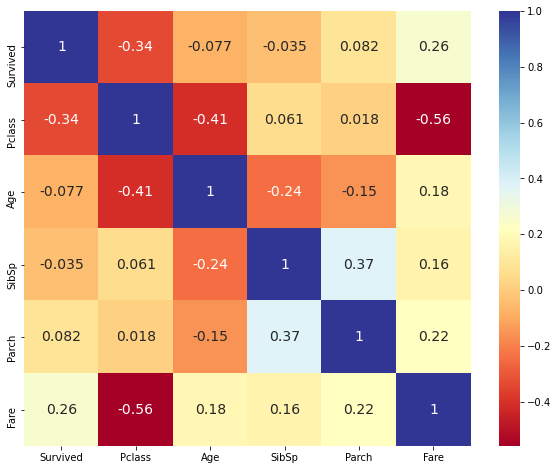

In [39]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(),annot=True,cmap='RdYlBu',annot_kws={'size':14})

- **Age** & **Fare** are highly correlated to **Pclass**

### Imputing missing values

####  Age

Since **Age** is highly correlated with **Pclass**, we will impute null values of age with median age, group by different **Pclass** and with different **Sex**

In [40]:
#median age of different pclass according to sex
df.groupby(['Sex','Pclass']).Age.median()

Sex     Pclass
female  1         36.0
        2         28.0
        3         22.0
male    1         42.0
        2         29.5
        3         25.0
Name: Age, dtype: float64

In [41]:
df['Age']=df.groupby(['Sex','Pclass'])['Age'].apply(lambda x:x.fillna(x.median()))

#### Fare

There is only one null value in fare column

In [42]:
df[df.Fare.isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


Since **Fare** is highly correlated with **Pclass** and assuming **Fare** is also correlated with family size, we will impute null **Fare** with median **Fare** of **Male** of **Pclass** 3 with no family(**SIbSp, Parch** = 0)

In [43]:
df['Fare']=df.groupby(['Pclass','SibSp','Parch'])['Fare'].apply(lambda x:x.fillna(x.median()))

#### Embarked

**Embarked** column has only 2 missing values

In [44]:
df[df.Embarked.isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


- Both the passengers have same **Ticket** number, **Fare** & **Cabin** number
- After searching on the web, it can be found that both of these passengers **Embarked** from Southampton

<img src='southampton.png'>

**image reference**  : <a href="https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html">Embarked info of Mrs Stone</a>

In [45]:
df['Embarked']=df['Embarked'].fillna('S')

#### Cabin

<AxesSubplot:xlabel='Cabin', ylabel='count'>

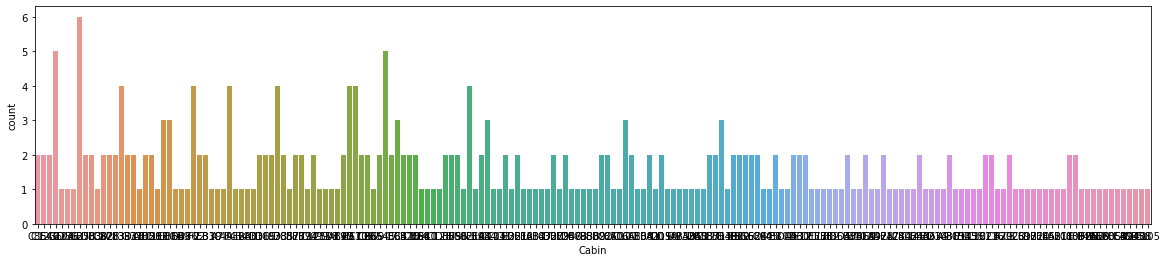

In [46]:
plt.figure(figsize=(20,4))
sns.countplot(df.Cabin)

- There are lots of unique values(High Cardinality) in **Cabin** so it will be difficut to impute null values

<AxesSubplot:ylabel='PassengerId'>

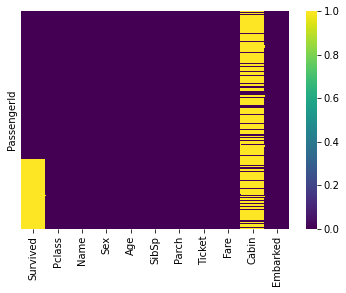

In [47]:
sns.heatmap(df.isnull(),yticklabels=False,cmap='viridis')

There are lots of null values in this column, so we have two options
- to drop this column

**OR**
- to replace Null values with a category 'M' means missing
Since this feature can be related to survival rate, I will go with the second option.
Also, the first letter of the **Cabin** name represents the deck name

In [48]:
#Creating a new feature to extract deck data from Cabin
#later, we can drop the Cabin column
df['deck']=df['Cabin'].apply(lambda x:x[0] if pd.notnull(x) else 'M')

<AxesSubplot:xlabel='deck', ylabel='count'>

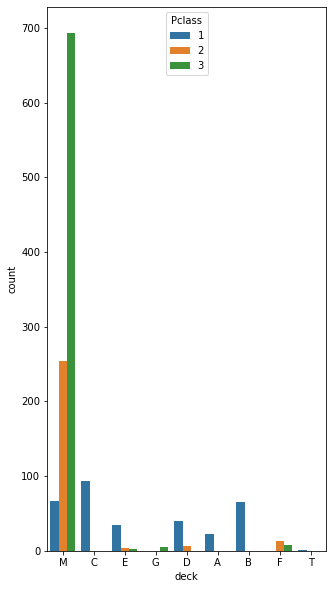

In [49]:
plt.figure(figsize=(5,10))
sns.countplot(data=df,x='deck',hue='Pclass')

In [50]:
pd.crosstab(df['deck'],df['Pclass'])

Pclass,1,2,3
deck,,,
A,22,0,0
B,65,0,0
C,94,0,0
D,40,6,0
E,34,4,3
F,0,13,8
G,0,0,5
M,67,254,693
T,1,0,0


Points that can be inferred from the above two plots
- **A, B, C & T** decks belong to first **Pclass** people
- Deck **D** has **40** people from **first Pclass** and **6** from **second Pclass**
- Deck **E** has **34** people from **first Pclass**, **4** from **second Pclass** and **3** from **third Pclass**
- Deck **F** has **13** people from **second Pclass** and **8** people from **third Pclass**
- **G** deck has people from **third Pclass**
- people with missing **Cabin/deck** values are mostly from **third Pclass**

<AxesSubplot:xlabel='deck', ylabel='count'>

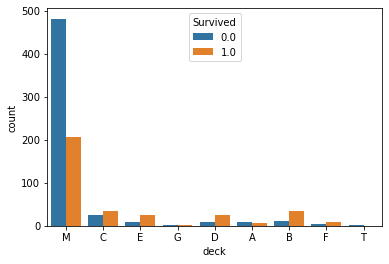

In [51]:
#checking survival rate deck-wise
sns.countplot(data=df,x='deck',hue='Survived')

- **deck B, C, D and E** have higher survival rate

Merging categories with similar characteristics into single category 
- Merging **A, B, C and T** in **ABCT** as all these decks belong to first class
- Merging **D and E** in **DE** as both of them have similar survival rate and similar **Pclass** distribution
- Merging **G and F** in **GF** because of the same reason

In [52]:
df['deck']=df['deck'].replace(['A','B','C','T'],'ABC')
df['deck']=df['deck'].replace(['G','F'],'GF')
df['deck']=df['deck'].replace(['D','E'],'DE')

df['deck'].value_counts()

M      1014
ABC     182
DE       87
GF       26
Name: deck, dtype: int64

In [53]:
df.isna().sum()

Survived     418
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin       1014
Embarked       0
deck           0
dtype: int64

#### Continuous Features

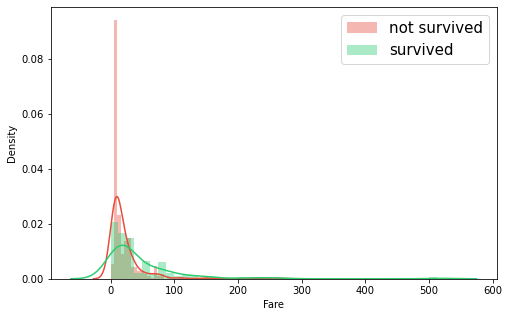

In [54]:
plt.figure(figsize=(8,5))
x1=sns.distplot(df[df['Survived']==0]['Fare'],color='#e74c3c',label='not survived')
sns.distplot(df[df['Survived']==1]['Fare'],color='#2ecc71',ax=x1,label='survived')
x1.legend(loc='upper right',prop={'size':15})

- Fare feature is right skewed because of outliers
- Fare feature has higher survival rate on tail side, that means people with very high fare have higher survival rate

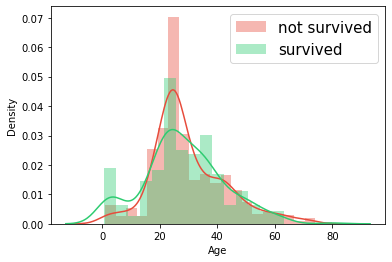

In [55]:
plt.figure(figsize=(6,4))
x1=sns.distplot(df[df['Survived']==0]['Age'],color='#e74c3c',label='not survived')
sns.distplot(df[df['Survived']==1]['Age'],color='#2ecc71',ax=x1,label='survived')
x1.legend(loc='upper right',prop={'size':15})

- Survival rate is higher at the left tail, that means survival rate is higher for young people

#### Categorical Features

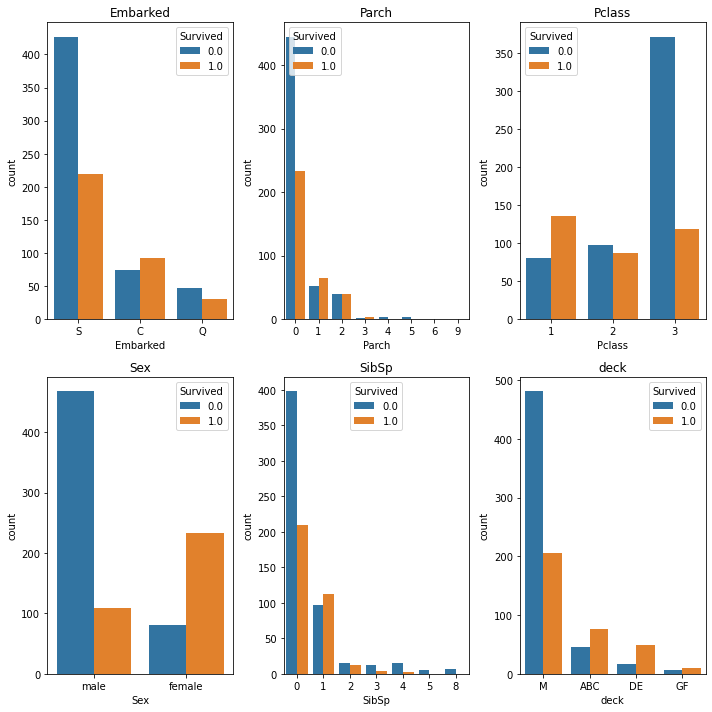

In [56]:
cat_features = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp', 'deck']

plt.figure(figsize=(10,10))

for i, feature in enumerate(cat_features):    
    plt.subplot(2, 3, i+1)
    sns.countplot(x=feature, hue='Survived', data=df)
    plt.title(feature)
    plt.tight_layout()

plt.show()

- people **Embarked** from **southampton** have low survival rate
- **Sibsp and Parch** have similar plots.people with either **no family** member or **more than 2 Sibsp/Parch** have low survival rate
- people from **Pclass** 3 have low survival rate
- **Females** have high Survival rate
- Survival rate is lowest for the **Missing(M)** values

### 4.2 Feature Engineering

In [57]:
#binning Fare - this feature has higher survival rate on right tail
# Also binning helps in dealing with the outliers
df['Fare']=pd.qcut(df['Fare'],13)

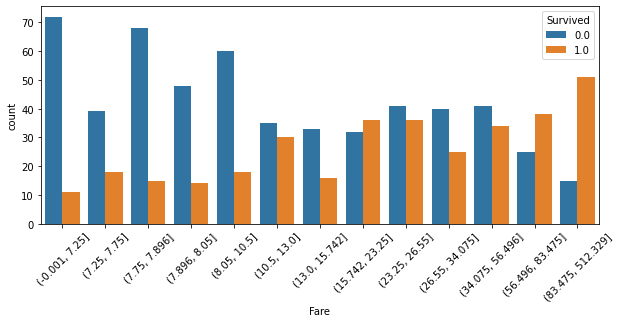

In [58]:
plt.figure(figsize=(10,4))
sns.countplot(data=df,x='Fare',hue='Survived')
plt.xticks(rotation=45);

In [59]:
# binnig Age - binning age for the same reason as fare
# Age feature has higher survival rate on the left tail
df['Age']=pd.qcut(df['Age'],10)

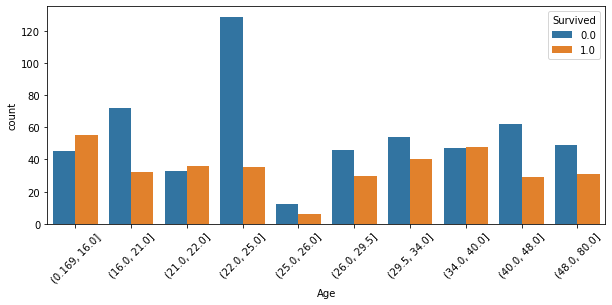

In [60]:
plt.figure(figsize=(10,4))
sns.countplot(data=df,x='Age',hue='Survived')
plt.xticks(rotation=45);

In [61]:
# creating new feature using Sibsp and Parch, as they have simlilar characteristics
df['Family']=df['SibSp']+df['Parch']

<AxesSubplot:xlabel='Family', ylabel='count'>

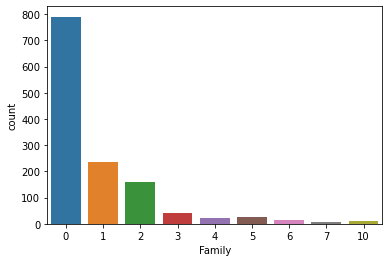

In [62]:
sns.countplot(df['Family'])

<AxesSubplot:xlabel='Family', ylabel='count'>

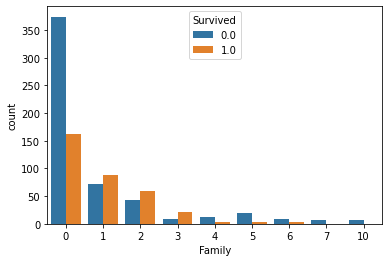

In [63]:
sns.countplot(data=df,x='Family',hue='Survived')

- family size=0 have low survival rate
- family size=1,2,3 have high survival rate
- family size=4,5 have low survival rate
- family size=6,7,10 have very low survival rate

In [64]:
#binning Family as they have different Survival rate in different ranges
mapping={0:'alone',1:'small',2:'small',3:'small',4:'medium',5:'medium',6:'large',7:'large',10:'large'}
df['Family_type']=df['Family'].map(mapping)

<AxesSubplot:xlabel='Family_type', ylabel='count'>

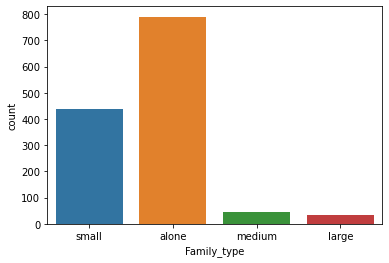

In [65]:
sns.countplot(df['Family_type'])

<AxesSubplot:xlabel='Family_type', ylabel='count'>

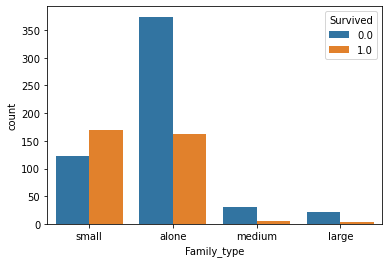

In [66]:
sns.countplot(data=df,x='Family_type',hue='Survived')

As ticket has too many unique values, creating new feature such as ticket_shared can help to identify the groups of people who travelled together

In [67]:
df['Ticket_shared']=df.groupby('Ticket')['Ticket'].transform('count')

<AxesSubplot:xlabel='Ticket_shared', ylabel='count'>

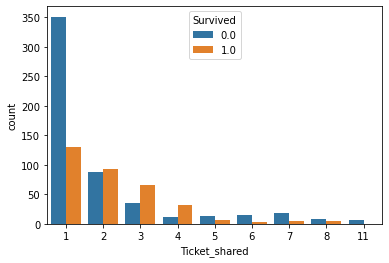

In [68]:
sns.countplot(df['Ticket_shared'],hue=df['Survived'])

- This feature has similar characteeristics of Family feature

Extracting title to get some more information like is there any special title who get priority for survival or about the marrital status of women

In [69]:
df['Title']=df['Name'].apply(lambda x:re.split(r'[.,]',x)[1].strip() )

In [70]:
df['Title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Ms                2
Mlle              2
Major             2
Jonkheer          1
Don               1
Mme               1
Dona              1
Lady              1
Sir               1
Capt              1
the Countess      1
Name: Title, dtype: int64

<AxesSubplot:xlabel='Title', ylabel='count'>

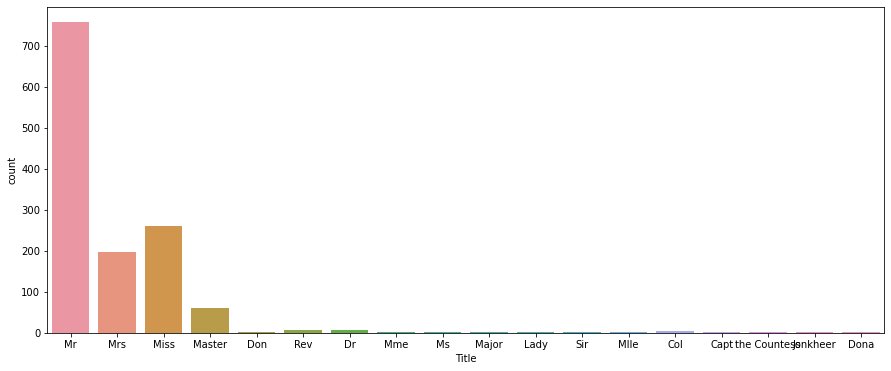

In [71]:
plt.figure(figsize=(15,6))
sns.countplot(df['Title'])

- **Miss, Ms, Mlle, Lady, Mme, the Countess, Dona** are all females so they will be grouped together
- **Mlle, Mme and Dona** are names but categorized as title because of our function used to extract title
- **Mrs** are married woman
- **Dr, Col, Major, Jonkheer, Capt, Sir, Don and Rev** are grouped together because of similar characteristics
- **Master** are the males below age 26. They have high Survival rate

In [72]:
df['Title']=df['Title'].replace(['Miss','Ms','Lady','Dona','Mme','Mlle','the Countess'],'ladies')
df['Title']=df['Title'].replace(['Dr','Col','Major','Jonkheer','Capt','Sir','Don','Rev'],'others')

<AxesSubplot:xlabel='Title', ylabel='count'>

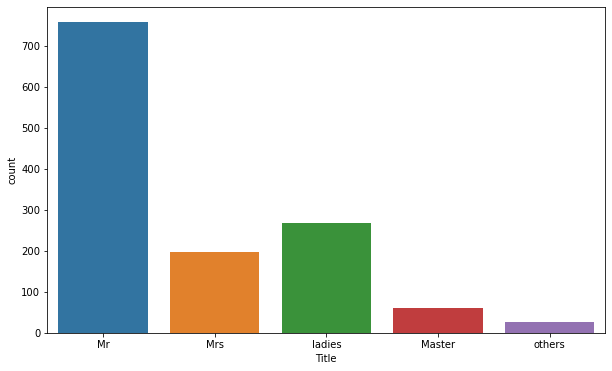

In [73]:
plt.figure(figsize=(10,6))
sns.countplot(df['Title'])

### 4.3 Target Encoding

A new feature is created with the help of Target/y_label. This is done by looking for categorical features which have high cardinality(**Ticket, Lastname**). Now in these features, look for the categories which are common in both training and test set. Then survival rate is calculated for these categories in training set with the help of y_label and since these categories are common in testing set as well, same value is used in testing set for these common categories.

**lastname** feature is created by extracting surname from **Name** feature. Then, a list : **common_lastname** is created containing surnames which are present in both training and test set.

**train_lastname_survival_rate** is calculated from training set as **Survived** column is only present in training set. This is done by extracting median Survival rate for family>0 by grouping training data by lastname. Then this survival rate will be mapped to the testing set for the **common lastname** in both the sets.

In [74]:
# creating Lastname feature
df['Lastname']=df['Name'].apply(lambda x:re.split(r'[.,]',x)[0].strip() )

In [75]:
df_train=df.loc[train.index]
df_test=df.loc[test.index]

In [76]:
# creating list of common surname present in both training and test set
common_lastname=[x for x in df_train['Lastname'].unique() if x in df_test['Lastname'].unique()]

#Median Survival rate from training set group by Lastname
train_lastname_survival_rate=df_train.groupby(['Lastname','Family'])['Survived'].median()


common_lastname_survival_rate={}

for i in range(len(train_lastname_survival_rate)):
    
    if train_lastname_survival_rate.index[i][0] in common_lastname and train_lastname_survival_rate.index[i][1]>0:
        
        common_lastname_survival_rate[train_lastname_survival_rate.index[i][0]]=train_lastname_survival_rate.iloc[i]

Similarly, **train_ticket_survival_rate** is calculated with the help of **Ticket** feature

In [77]:
common_ticket=[x for x in df_train['Ticket'].unique() if x in df_test['Ticket'].unique()]

train_ticket_survival_rate=df_train.groupby(['Ticket','Ticket_shared'])['Survived'].median()

common_ticket_survival_rate={}

for i in range(len(train_ticket_survival_rate)):
    
    if train_ticket_survival_rate.index[i][0] in common_ticket and train_ticket_survival_rate.index[i][1]>1:
        
        common_ticket_survival_rate[train_ticket_survival_rate.index[i][0]]=train_ticket_survival_rate.iloc[i]

So far we have created dictionaries of **common_lastname_survival_rate**, which contains common **lastname** as keys, and survival rate as their values. Now we need to create a new feature called as **train_lastname_survival_rate** by mapping survival rate values with their corresponding **lastname**.For **Lastname** which do not exist in the **common_lastname_survival_rate** dictionary, we will use mean value of survival rate.

Also, an additional feature called as **train_lastname_survival_rate_NA** will be used. This will be set to **1** for those having common **lastname** in **train** and **test** set, and **0** for those who dont have common **lastname** in both the sets. This feature will help to proiritize those survival rates which are calculated from common **lastname**

In [78]:
mean_survival_rate=np.mean(df_train['Survived'])

train_lastname_survival_rate=[]
train_lastname_survival_rate_NA=[]

for i in range(len(df_train)):
    
    if df_train['Lastname'].iloc[i] in common_lastname_survival_rate:
        
        train_lastname_survival_rate.append(common_lastname_survival_rate[df_train['Lastname'].iloc[i]])
        train_lastname_survival_rate_NA.append(1)
        
    else:
        
        train_lastname_survival_rate.append(mean_survival_rate)
        train_lastname_survival_rate_NA.append(0)

df_train['lastname_survival_rate']=train_lastname_survival_rate
df_train['lastname_survival_rate_NA']=train_lastname_survival_rate_NA

similarly, this is done for testing set

In [79]:
test_lastname_survival_rate=[]
test_lastname_survival_rate_NA=[]

for i in range(len(df_test)):
    
    if df_test['Lastname'].iloc[i] in common_lastname_survival_rate:
        
        test_lastname_survival_rate.append(common_lastname_survival_rate[df_test['Lastname'].iloc[i]])
        test_lastname_survival_rate_NA.append(1)
        
    else:
        
        test_lastname_survival_rate.append(mean_survival_rate)
        test_lastname_survival_rate_NA.append(0)
        
df_test['lastname_survival_rate']=test_lastname_survival_rate
df_test['lastname_survival_rate_NA']=test_lastname_survival_rate_NA

Similarly **train_ticket_survival_rate** and **train_ticket_survival_rate_NA** is created for both training and test set

In [80]:
train_ticket_survival_rate=[]
train_ticket_survival_rate_NA=[]

for i in range(len(df_train)):
    
    if df_train['Ticket'].iloc[i] in common_ticket_survival_rate:
        
        train_ticket_survival_rate.append(common_ticket_survival_rate[df_train['Ticket'].iloc[i]])    
        train_ticket_survival_rate_NA.append(1)
        
    else:
        
        train_ticket_survival_rate.append(mean_survival_rate)
        train_ticket_survival_rate_NA.append(0)
        
df_train['ticket_survival_rate']=train_ticket_survival_rate
df_train['ticket_survival_rate_NA']=train_ticket_survival_rate_NA

In [81]:
test_ticket_survival_rate=[]
test_ticket_survival_rate_NA=[]

for i in range(len(df_test)):
    
    if df_test['Ticket'].iloc[i] in common_ticket_survival_rate:
        
        test_ticket_survival_rate.append(common_ticket_survival_rate[df_test['Ticket'].iloc[i]])    
        test_ticket_survival_rate_NA.append(1)
        
    else:
        
        test_ticket_survival_rate.append(mean_survival_rate)
        test_ticket_survival_rate_NA.append(0)
        
df_test['ticket_survival_rate']=test_ticket_survival_rate
df_test['ticket_survival_rate_NA']=test_ticket_survival_rate_NA

Now we will take mean of **ticket_survival_rate** and **lastname_survival_rate** to create a single **survival_rate** column. Similarly for **survival_rate_NA**

In [82]:
for table in [df_train,df_test]:
    
    table['survival_rate']=(table['lastname_survival_rate']+table['ticket_survival_rate'])/2
    table['survival_rate_NA']=(table['lastname_survival_rate_NA']+table['ticket_survival_rate_NA'])/2

### 4.4 Feature Selection

In [83]:
df=pd.concat([df_train,df_test],axis=0,sort=False)

In [84]:
df.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'deck', 'Family', 'Family_type',
       'Ticket_shared', 'Title', 'Lastname', 'lastname_survival_rate',
       'lastname_survival_rate_NA', 'ticket_survival_rate',
       'ticket_survival_rate_NA', 'survival_rate', 'survival_rate_NA'],
      dtype='object')

Dropping the following features :
- **Name** - **Title** is extracted from this feature
- **Cabin** - **deck** is extracted from this feature
- **SibSp, Parch and Family** - **Family_type** is extracted from this feature
- **Ticket, Lastname** - **survival_rate** is created from this feature
- **lastname_survival_rate, ticket_survival_rate** - **survival_rate** is created from this feature.
- **lastname_survival_rate_NA, ticket_survival_rate_NA** - **survival_rate_NA** is created from this feature

In [85]:
df.drop(['Name','SibSp','Parch','Cabin','Ticket','Family','Lastname',
         'lastname_survival_rate','lastname_survival_rate_NA',
         'ticket_survival_rate','ticket_survival_rate_NA'],axis=1,inplace=True)

### 4.5 Label Encoding

In [86]:
df['Age']=le.fit_transform(df['Age'])
df['Fare']=le.fit_transform(df['Fare'])

In [87]:
df=pd.get_dummies(df,drop_first=True)

In [88]:
df.head()

,Survived,Pclass,Age,Fare,Ticket_shared,survival_rate,survival_rate_NA,Sex_male,Embarked_Q,Embarked_S,deck_DE,deck_GF,deck_M,Family_type_large,Family_type_medium,Family_type_small,Title_Mr,Title_Mrs,Title_ladies,Title_others
PassengerId,,,,,,,,,,,,,,,,,,,,
1,0.0,3,2,0,1,0.383838,0.0,1,0,1,0,0,1,0,0,1,1,0,0,0
2,1.0,1,7,11,2,1.000000,1.0,0,0,0,0,0,0,0,0,1,0,1,0,0
3,1.0,3,4,3,1,0.383838,0.0,0,0,1,0,0,1,0,0,0,0,0,1,0
4,1.0,1,7,10,2,0.383838,0.0,0,0,1,0,0,0,0,0,1,0,1,0,0
5,0.0,3,7,3,1,0.383838,0.0,1,0,1,0,0,1,0,0,0,1,0,0,0


### 4.6 Model Selection

In [89]:
df_train=df.loc[train.index]
df_test=df.loc[test.index]
df_test.drop('Survived',axis=1,inplace=True)

In [90]:
x=df_train.drop('Survived',axis=1)
y=df_train['Survived']

In [91]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

Our Model for this approach will be a tuned **RandomForestClassifier**

In [92]:
sbm = RandomForestClassifier(criterion='gini', 
                                           n_estimators=1100,
                                           max_depth=5,
                                           min_samples_split=4,
                                           min_samples_leaf=5,
                                           max_features='auto',
                                           oob_score=True,
                                           n_jobs=-1)

sbm.fit(x_train,y_train)

y_pred=sbm.predict(x_test)
print('Accuracy Score: ',accuracy_score(y_test,y_pred))

ypred=sbm.predict(x_train)
print('training accuracy: ',accuracy_score(y_train,ypred))

score=cross_val_score(sbm,x,y,cv=5)
print('\nCross validation score :\n',score)
print('\nMean cross validation score: ',score.mean())

Accuracy Score:  0.8659217877094972
training accuracy:  0.8567415730337079

Cross validation score :
 [0.88268156 0.83146067 0.83707865 0.81460674 0.86516854]

Mean cross validation score:  0.8461992341974766


In [93]:
#Training the with with complete data
sbm.fit(x,y)

RandomForestClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=4,
                       n_estimators=1100, n_jobs=-1, oob_score=True)

In [94]:
prediction=sbm.predict(df_test)

In [95]:
pred_file2=pd.DataFrame({'PassengerId':dft['PassengerId'],
                       'Survived':prediction})

pred_file2['Survived']=pred_file2['Survived'].astype('i')

In [96]:
pred_file2.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


Testing score of this model is : **79.90%**

## 5. Ensemble

In [97]:
#importing gender_submission file
pred_file3=pd.read_csv('gender_submission.csv')
pred_file3.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [98]:
df_ensemble=pred_file1.copy()

In [99]:
x='Survived'
x1=0.3
x2=0.3
x3=0.4

In [100]:
df_ensemble[x]=x1*pred_file1[x]+x2*pred_file2[x]+x3*pred_file3[x]
df_ensemble[x]=df_ensemble[x].apply(lambda y : 1 if y>=0.5 else 0)
df_ensemble.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [101]:
df_ensemble.to_csv('ensemble(top3).csv',index=False)

**References**  : 

- <a href="https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial">Titanic-Advanced Feature Engineering Tutorial</a>
- <a href="https://www.kaggle.com/stever4/titanic-top-5-0-8-with-simple-rules-no-ml">Titanic: Top 5% (>0.8) with simple rules (no ML)</a>
- <a href="https://www.kaggle.com/imoore/titanic-the-only-notebook-you-need-to-see">Titanic-The Only Notebook You Need To See</a>